In [3]:
# 필수 라이브러리
import pandas as pd
import numpy as np
import geopandas as gpd
from pathlib import Path

import matplotlib.pyplot as plt
plt.rcParams['font.family'] = 'MalgunGothic'
plt.rcParams['axes.unicode_minus'] = False

data_dir = Path("/mnt/c/Source/python/AST-GCN/res")
dataset_dir = data_dir / "SEOUL_TRAFFIC_DATASET"

csv_paths = sorted(dataset_dir.glob("SEOUL_TRAFFIC_DATASET_*.csv"))

dfs = []
for p in csv_paths:
    df = pd.read_csv(p)
    
    # 월 정보 컬럼 추가 (예: 'SEOUL_TRAFFIC_DATASET_202501' -> '202501')
    ym = p.stem.split("_")[-1]   # 마지막 토큰이 202501 이런 형식
    df["YearMonth"] = ym
    
    dfs.append(df)

all_df = pd.concat(dfs, ignore_index=True)

csv_path  = data_dir / "SEOUL_TRAFFIC_DATASET_2025.csv"
all_df.to_csv(csv_path, index=False)

gpkg_path = data_dir / "seoul_drive_net.gpkg"


### 서울시 버스 이용량 & 속도 데이터

In [4]:
node_df = pd.read_csv(csv_path)
# 기본 타입 정리
node_df["osmid"] = node_df["osmid"].astype(int)
node_df["Hour"] = node_df["Hour"].astype(int)
node_df["YearMonth"] = node_df["YearMonth"].astype(str)

# 결측치를 0으로
value_cols = ["TotalTraffic", "GetOn", "GetOff", "RouteCount", "Speed"]
node_df[value_cols] = node_df[value_cols].fillna(0.0)

print("전체 행 수:", len(node_df))
print("고유 osmid 개수:", node_df["osmid"].nunique())
print("고유 YearMonth:", sorted(node_df["YearMonth"].unique()))

전체 행 수: 5582736
고유 osmid 개수: 23269
고유 YearMonth: ['202501', '202502', '202503', '202504', '202505', '202506', '202507', '202508', '202509', '202510']


In [5]:
# 노드별 하루/월 전체에서 TotalTraffic 합계
agg = node_df.groupby("osmid")["TotalTraffic"].sum()

# 버스가 한 번이라도 있었던 노드만
bus_nodes = agg[agg > 0].index.to_numpy()
valid_nodes = np.sort(bus_nodes)

print("버스 있는 노드 개수:", len(valid_nodes))

# 해당 노드만 남기기 (speed-only 노드와 완전 empty 노드는 버림)
node_df = node_df[node_df["osmid"].isin(valid_nodes)].copy()


버스 있는 노드 개수: 7355


In [6]:
# 버스가 있었던 시점
mask_bus = node_df["TotalTraffic"] > 0

# Speed 값이 유효한 시점 (0 초과)
mask_speed_valid = node_df["Speed"] > 0

print("버스 있는 시점(row) 수 :", node_df.loc[mask_bus].shape[0])
print("Speed>0 인 시점(row) 수:", node_df.loc[mask_speed_valid].shape[0])

# 둘 다 만족하는 행만 살리기
mask_both = mask_bus & mask_speed_valid
node_df = node_df[mask_both].copy()

print("버스+Speed 둘 다 있는 시점(row) 수:", node_df.shape[0])

버스 있는 시점(row) 수 : 1515380
Speed>0 인 시점(row) 수: 1204560
버스+Speed 둘 다 있는 시점(row) 수: 1057228


### 서울시 노드 정보 데이터

In [7]:
import fiona
fiona.listlayers(gpkg_path)

['nodes', 'edges']

In [8]:
edges_gdf = gpd.read_file(gpkg_path, layer="edges")
nodes_gdf = gpd.read_file(gpkg_path, layer="nodes")

edges_gdf.head(), edges_gdf.info()
nodes_gdf.head(), nodes_gdf.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
RangeIndex: 103620 entries, 0 to 103619
Data columns (total 21 columns):
 #   Column    Non-Null Count   Dtype   
---  ------    --------------   -----   
 0   u         103620 non-null  int64   
 1   v         103620 non-null  int64   
 2   key       103620 non-null  int64   
 3   osmid     103620 non-null  object  
 4   highway   103620 non-null  object  
 5   name      103620 non-null  object  
 6   oneway    103620 non-null  bool    
 7   reversed  103620 non-null  object  
 8   length    103620 non-null  float64 
 9   from      103620 non-null  int64   
 10  to        103620 non-null  int64   
 11  lanes     103620 non-null  object  
 12  maxspeed  103620 non-null  object  
 13  ref       103620 non-null  object  
 14  bridge    103620 non-null  object  
 15  tunnel    103620 non-null  object  
 16  junction  103620 non-null  object  
 17  access    103620 non-null  object  
 18  width     103620 non-null  object  
 19  service   10362

(       osmid          y           x  street_count junction highway ref  \
 0  266813237  37.526615  127.000794             3                        
 1  278159482  37.525964  126.997422             3                        
 2  278159676  37.527696  127.002375             3                        
 3  282723724  37.588055  127.023541             3                        
 4  282723780  37.586624  127.025199             3                        
 
   railway                    geometry  
 0          POINT (127.00079 37.52662)  
 1          POINT (126.99742 37.52596)  
 2           POINT (127.00238 37.5277)  
 3          POINT (127.02354 37.58805)  
 4           POINT (127.0252 37.58662)  ,
 None)

In [9]:
# 좌표계 확인 (위경도)
print(edges_gdf.crs)
print(nodes_gdf.crs)

EPSG:4326
EPSG:4326


findfont: Font family 'MalgunGothic' not found.
findfont: Font family 'MalgunGothic' not found.
findfont: Font family 'MalgunGothic' not found.
findfont: Font family 'MalgunGothic' not found.
findfont: Font family 'MalgunGothic' not found.
findfont: Font family 'MalgunGothic' not found.
findfont: Font family 'MalgunGothic' not found.
findfont: Font family 'MalgunGothic' not found.
findfont: Font family 'MalgunGothic' not found.
findfont: Font family 'MalgunGothic' not found.
findfont: Font family 'MalgunGothic' not found.
findfont: Font family 'MalgunGothic' not found.
findfont: Font family 'MalgunGothic' not found.
findfont: Font family 'MalgunGothic' not found.
findfont: Font family 'MalgunGothic' not found.
findfont: Font family 'MalgunGothic' not found.
findfont: Font family 'MalgunGothic' not found.
findfont: Font family 'MalgunGothic' not found.
findfont: Font family 'MalgunGothic' not found.
findfont: Font family 'MalgunGothic' not found.
findfont: Font family 'MalgunGothic' not

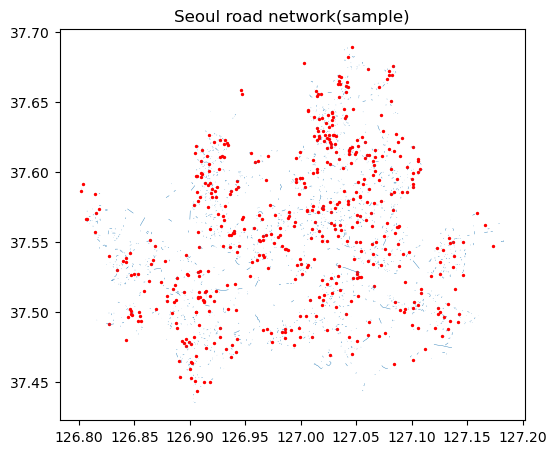

In [10]:
ax = edges_gdf.sample(min(2000, len(edges_gdf))).plot(figsize=(6,6), linewidth=0.3)
nodes_gdf.sample(min(500, len(nodes_gdf))).plot(ax=ax, markersize=2, color="red")
plt.title("Seoul road network(sample)")
plt.show()

### 데이터 조인

In [11]:
nodes_gdf.columns

Index(['osmid', 'y', 'x', 'street_count', 'junction', 'highway', 'ref',
       'railway', 'geometry'],
      dtype='object')

In [12]:
# 노드 좌표만 추출
node_xy = nodes_gdf[["osmid", "geometry"]].copy()

# 시계열 데이터와 merge (각 osmid의 Hour별 데이터가 좌표를 가지게 됨)
node_with_geo = node_df.merge(node_xy, on="osmid", how="left")

node_with_geo["geometry"].isna().mean()  # 좌표 없는 행 비율

node_with_geo

,osmid,Hour,TotalTraffic,GetOn,GetOff,RouteCount,Speed,YearMonth,geometry
0,287287152,0,85.0,3.0,82.0,1.0,29.584509,202501,POINT (127.03458 37.55393)
1,287287152,5,8.0,0.0,8.0,1.0,29.910714,202501,POINT (127.03458 37.55393)
2,287287152,6,27.0,11.0,16.0,1.0,28.036205,202501,POINT (127.03458 37.55393)
3,287287152,7,194.0,120.0,74.0,1.0,25.938378,202501,POINT (127.03458 37.55393)
4,287287152,8,249.0,129.0,120.0,1.0,23.686548,202501,POINT (127.03458 37.55393)
...,...,...,...,...,...,...,...,...,...
1057223,13239391603,19,1721.0,1344.0,377.0,1.0,32.413226,202510,POINT (127.00253 37.60745)
1057224,13239391603,20,1430.0,1063.0,367.0,1.0,35.646089,202510,POINT (127.00253 37.60745)
1057225,13239391603,21,1246.0,953.0,293.0,1.0,37.876109,202510,POINT (127.00253 37.60745)
1057226,13239391603,22,1230.0,847.0,383.0,1.0,39.246996,202510,POINT (127.00253 37.60745)


### osmid -> index 변환

In [13]:
# 모델에 쓸 "유효 노드 목록" (정렬된 고유 osmid)
valid_nodes = np.sort(node_df["osmid"].unique())
print("노드 개수 N =", len(valid_nodes))

노드 개수 N = 5019


In [14]:
node2idx = {osmid: i for i, osmid in enumerate(valid_nodes)}

# map 을 이용해 osmid → index 변환
node_df["node_idx"] = node_df["osmid"].map(node2idx)

node_df[["osmid","node_idx"]]


,osmid,node_idx
72,287287152,0
77,287287152,0
78,287287152,0
79,287287152,0
80,287287152,0
...,...,...
5582515,13239391603,5018
5582516,13239391603,5018
5582517,13239391603,5018
5582518,13239391603,5018


In [15]:
nodes_gdf["osmid"] = nodes_gdf["osmid"].astype(int)

# 그래프에 실제로 쓸 노드만 필터링
nodes_gdf = nodes_gdf[nodes_gdf["osmid"].isin(valid_nodes)].copy()

nodes_gdf["node_idx"] = nodes_gdf["osmid"].map(node2idx)

nodes_gdf[["osmid","node_idx"]]

,osmid,node_idx
9,287287152,0
30,287631232,1
45,287712330,2
48,287725957,3
66,292077483,4
...,...,...
68314,13233950656,5014
68318,13236318521,5015
68322,13238957909,5016
68324,13239386673,5017


In [16]:
# 인덱스 테이블 저장
idx_df = pd.DataFrame({
    "node_idx": np.arange(len(valid_nodes)),
    "osmid": valid_nodes
})

idx_df.to_csv(data_dir / "node_index_map.csv", index=False)


### 인접 행렬 A 생성

In [17]:
import scipy.sparse as sp

gpkg_path = data_dir / "seoul_drive_net.gpkg"

# 1) edges 레이어 읽기
edges_gdf = gpd.read_file(gpkg_path, layer="edges")

# u, v 가 정수 osmid 라고 가정 (지금 gpkg가 그렇게 되어 있음)
edges_gdf["u"] = edges_gdf["u"].astype(int)
edges_gdf["v"] = edges_gdf["v"].astype(int)

# 2) 우리가 가진 시계열 노드(valid_nodes)에 해당하는 간선만 남기기
valid_set = set(valid_nodes)
mask = edges_gdf["u"].isin(valid_set) & edges_gdf["v"].isin(valid_set)
edges_sub = edges_gdf[mask].copy()

print("원래 edge 수:", len(edges_gdf))
print("버스 데이터와 겹치는 edge 수:", len(edges_sub))
edges_sub.head()[["u","v","length","oneway"]]


원래 edge 수: 103620
버스 데이터와 겹치는 edge 수: 2026


,u,v,length,oneway
100,287631232,287712330,15.333853,False
141,287712330,5871218814,82.777407,True
202,292077483,292077487,28.665153,False
205,292077487,292077490,80.934053,False
224,298309258,436849137,123.619067,False


In [18]:
# osmid → node_idx
edges_sub["u_idx"] = edges_sub["u"].map(node2idx)
edges_sub["v_idx"] = edges_sub["v"].map(node2idx)

# 잘 매핑됐는지 확인
edges_sub[["u","v","u_idx","v_idx"]]

,u,v,u_idx,v_idx
100,287631232,287712330,1,2
141,287712330,5871218814,2,4208
202,292077483,292077487,4,5
205,292077487,292077490,5,6
224,298309258,436849137,7,422
...,...,...,...,...
103570,13208298986,13208298987,4990,4991
103588,13231411180,13231411181,5008,5009
103590,13231411200,13231439304,5012,5013
103591,13231411200,13231439304,5012,5013


In [19]:
# 희소 인접행렬 만들기 (무가중치, undirected)

N = len(valid_nodes)

row = edges_sub["u_idx"].to_numpy()
col = edges_sub["v_idx"].to_numpy()

# 일단 방향 그래프(한쪽 방향만)
data = np.ones_like(row, dtype=np.float32)
A = sp.coo_matrix((data, (row, col)), shape=(N, N))

# undirected 로 만들기 (A 또는 A^T 중 큰 값 사용)
A_sym = A + A.T.multiply(A.T > A) - A.multiply(A.T > A)

print("노드 수:", N)
print("간선 수(방향성 제거 후 nnz):", A_sym.nnz)


노드 수: 5019
간선 수(방향성 제거 후 nnz): 3999


In [20]:
# 3-4. self-loop 추가 + 정규화 
# GCN 계열에서 많이 쓰는 방식

# 1) self-loop 추가
I = sp.eye(N, format="coo")
A_tilde = A_sym + I

# 2) degree 벡터
deg = np.array(A_tilde.sum(axis=1)).flatten()  # 각 노드 degree
deg_inv_sqrt = 1.0 / np.sqrt(deg)
deg_inv_sqrt[np.isinf(deg_inv_sqrt)] = 0.0

D_inv_sqrt = sp.diags(deg_inv_sqrt)

# 3) 정규화 인접행렬
A_norm = D_inv_sqrt @ A_tilde @ D_inv_sqrt    # sparse matrix 그대로 유지

print(A_norm.shape, A_norm.nnz)



(5019, 5019) 9013


In [21]:
# dense 행렬 저장
# ~7355x7355 -> 약 200MB 정도

A_dense = A_norm.toarray().astype(np.float32)
np.save(data_dir / "adjacency_norm.npy", A_dense)

### 시계열 텐서 X 생성
    목표: X를 [N, T, F] = [노드 수, 시간(24), 피처 수] 형태의 numpy 배열로 만드는 것.

In [22]:
# 노드 수 N
N = node_df["node_idx"].max() + 1

# 시간축 T (보통 0~23)
hours = sorted(node_df["Hour"].unique())
T = len(hours)

# 사용할 피처들
feature_cols = ["TotalTraffic", "GetOn", "GetOff", "RouteCount", "Speed"]
F = len(feature_cols)

yearmonths = sorted(node_df["YearMonth"].unique())


print("N =", N, " / T =", T, " / F =", F)

N = 5019  / T = 24  / F = 5


In [23]:
# 월별 텐서 생성 함수
def build_X_for_month(df_month, N, hours, feature_cols):
    T = len(hours)
    F = len(feature_cols)

    # 텐서 초기화
    X = np.zeros((N, T, F), dtype=np.float32)

    for feat_i, feat_name in enumerate(feature_cols):
        # (node_idx, Hour) -> 값 매트릭스
        tmp = df_month.pivot(index="node_idx", columns="Hour", values=feat_name)
        
        # node_idx 0~N-1, Hour는 hours 순서로 재정렬/재인덱스
        tmp = tmp.reindex(index=np.arange(N), columns=hours)

        # 결측치 있으면 0으로
        tmp = tmp.fillna(0.0)

        # numpy로 변환해서 X에 넣기 (shape: [N, T])
        X[:, :, feat_i] = tmp.to_numpy(dtype=np.float32)
    return X

# X[i, t, :] → i번 노드, t번째 시간(hours[t] 시)의
# [TotalTraffic, GetOn, GetOff, RouteCount, Speed] 벡터

In [24]:
# 모든 월에 대해 X_all 생성
X_month_list = []
for ym in yearmonths:
    df_m = node_df[node_df["YearMonth"] == ym].copy()
    X_m = build_X_for_month(df_m, N, hours, feature_cols)   # (N, 24, 5)
    X_month_list.append(X_m)

X_all = np.stack(X_month_list, axis=0)     # (M, N, T, F)
M, N, T, F = X_all.shape
print("X_all shape:", X_all.shape)

X_all shape: (10, 5019, 24, 5)


In [25]:
# 정규화 (feature scaling)

# 전체 (N, T) 축에 대해 피처별 평균/표준편차
feat_mean = X_all.reshape(-1, F).mean(axis=0)
feat_std  = X_all.reshape(-1, F).std(axis=0) + 1e-8  # 0 나누기 방지

X_all_norm = (X_all - feat_mean) / feat_std

print("mean:", feat_mean)
print("std:", feat_std)
print("X_norm shape:", X_all_norm.shape)

mean: [1.8310161e+03 9.3035236e+02 9.0044159e+02 9.5134616e-01 2.0520054e+01]
std: [3.2120969e+03 1.7736555e+03 1.6837496e+03 4.1420573e-01 9.1429882e+00]
X_norm shape: (10, 5019, 24, 5)


In [26]:
# 저장
np.save(data_dir / "X_all_months.npy", X_all)
np.save(data_dir / "X_all_months_norm.npy", X_all_norm)
np.save(data_dir / "valid_nodes.npy", valid_nodes)
np.save(data_dir / "feature_mean_std.npy",
        np.vstack([feat_mean, feat_std]))

### 슬라이딩 윈도우로 학습 샘플 만들기

In [27]:
T_in = 8
T_out = 1
target_idx = 0   # TotalTraffic

def create_sliding_samples_per_month(X_month, T_in, T_out, idx_traffic=0, idx_speed=4):
    
    """
    X_month: (N, T, F)  ← 정규화된 X (X_all_norm[m])
    return:
      X_s: (num_samples, N, T_in, F)
      Y_s: (num_samples, N, T_out, 2)  ← [TotalTraffic, Speed]
    """
    
    N, T, F = X_month.shape
    max_start = T - T_in - T_out
    X_list, Y_list = [], []

    for t_start in range(max_start + 1):
        t_end_in = t_start + T_in
        t_end_out = t_end_in + T_out

        x_win = X_month[:, t_start:t_end_in, :]                # (N, T_in, F)
        y_traffic = X_month[:, t_end_in:t_end_out, idx_traffic] # (N, T_out)
        y_speed   = X_month[:, t_end_in:t_end_out, idx_speed]   # (N, T_out)
        y_win = np.stack([y_traffic, y_speed], axis=-1)

        X_list.append(x_win)
        Y_list.append(y_win)

    return (np.stack(X_list, axis=0),
            np.stack(Y_list, axis=0))

X_samples_list, Y_samples_list = [], []
for m in range(len(yearmonths)):
    X_m_norm = X_all_norm[m]   # (N, T, F)
    X_s, Y_s = create_sliding_samples_per_month(
        X_m_norm, T_in, T_out, idx_traffic=0, idx_speed=4)
    X_samples_list.append(X_s)
    Y_samples_list.append(Y_s)

X_samples = np.concatenate(X_samples_list, axis=0)   # (total_samples, N, T_in, F)
Y_samples = np.concatenate(Y_samples_list, axis=0)   # (total_samples, N, T_out, 2)

print("최종 X_samples:", X_samples.shape)
print("최종 Y_samples:", Y_samples.shape)

np.save(data_dir / "X_samples.npy", X_samples)
np.save(data_dir / "Y_samples.npy", Y_samples)


최종 X_samples: (160, 5019, 8, 5)
최종 Y_samples: (160, 5019, 1, 2)


In [31]:
# 1) 월별 텐서 (정규화된 것) 로드
X_all_months_norm = np.load(data_dir / "X_all_months_norm.npy")  # (M, N, T, F)
print("X_all_months_norm shape:", X_all_months_norm.shape)

M, N, T_hour, F = X_all_months_norm.shape  # 예: M=10, N=..., T_hour=24, F=5

# 2) 월 축을 시간 축으로 펼치기
#    (M, N, T, F) → (N, M, T, F) → (N, M*T, F)
X_all_norm = (
    X_all_months_norm
    .transpose(1, 0, 2, 3)        # (N, M, T, F)
    .reshape(N, M * T_hour, F)    # (N, T_total, F)
)

print("X_all_norm for AST-GCN:", X_all_norm.shape)  # (N, T_total, F)

# (필요하면 ST-GCN 쪽에서도 이걸 공유해서 써도 됨)
np.save(data_dir / "X_all_norm_for_ast.npy", X_all_norm)

X_all_months_norm shape: (10, 5019, 24, 5)
X_all_norm for AST-GCN: (5019, 240, 5)


In [32]:
# AST-GCN 샘플 생성 함수

def build_astgcn_samples(
    X_all: np.ndarray,
    T_h: int = 8,         # recent 길이
    D_d: int = 2,         # daily 과거 일수 (t-24, t-48)
    D_w: int = 1,         # weekly 과거 주수 (t-7*24)
    P_d: int = 24,        # 하루 간격
    P_w: int = 24 * 7,    # 일주일 간격
    T_out: int = 1,       # 예측 horizon
    idx_traffic: int = 0, # TotalTraffic 인덱스
    idx_speed: int = 4,   # Speed 인덱스
):
    """
    X_all: (N, T, F)  정규화된 전체 시계열
    반환:
      Xh: (S, N, T_h, F)
      Xd: (S, N, D_d, F)  ← 하루 간격 샘플들
      Xw: (S, N, D_w, F)  ← 주간 간격 샘플들
      Y : (S, N, T_out, 2)  ← [TotalTraffic, Speed]
    """
    X_all = np.asarray(X_all)
    if X_all.ndim != 3:
        raise ValueError(f"X_all.ndim={X_all.ndim}, (N,T,F) 이어야 합니다.")

    N, T, F = X_all.shape
    print(f"[build_astgcn_samples] N={N}, T={T}, F={F}")

    # 과거 history를 다 만족할 수 있는 최소 t
    t_min = max(
        T_h,
        D_d * P_d if D_d > 0 else 0,
        D_w * P_w if D_w > 0 else 0,
    )
    # 예측 가능한 최대 t (t..t+T_out-1 이 범위를 벗어나면 안 됨)
    t_max = T - T_out

    print(f"t_min={t_min}, t_max={t_max} (총 usable 타임스텝: {t_max - t_min})")

    Xh_list, Xd_list, Xw_list, Y_list = [], [], [], []

    for t in range(t_min, t_max):
        # 1) recent: 바로 직전 T_h 타임스텝 (t-T_h .. t-1)
        xh = X_all[:, t - T_h:t, :]      # (N, T_h, F)

        # 2) daily: t - k*P_d (k = 1..D_d)
        if D_d > 0:
            xd_steps = []
            for k in range(1, D_d + 1):
                t_d = t - k * P_d
                xd_steps.append(X_all[:, t_d, :][:, None, :])  # (N, 1, F)
            xd = np.concatenate(xd_steps, axis=1)              # (N, D_d, F)
        else:
            xd = None

        # 3) weekly: t - k*P_w (k = 1..D_w)
        if D_w > 0:
            xw_steps = []
            for k in range(1, D_w + 1):
                t_w = t - k * P_w
                xw_steps.append(X_all[:, t_w, :][:, None, :])  # (N, 1, F)
            xw = np.concatenate(xw_steps, axis=1)              # (N, D_w, F)
        else:
            xw = None

        # 4) 타깃: t..t+T_out-1 의 TotalTraffic, Speed
        y_tr = X_all[:, t:t+T_out, idx_traffic]  # (N, T_out)
        y_sp = X_all[:, t:t+T_out, idx_speed]    # (N, T_out)
        y = np.stack([y_tr, y_sp], axis=-1)      # (N, T_out, 2)

        Xh_list.append(xh)
        if xd is not None:
            Xd_list.append(xd)
        if xw is not None:
            Xw_list.append(xw)
        Y_list.append(y)

    Xh = np.stack(Xh_list, axis=0)  # (S, N, T_h, F)
    Y  = np.stack(Y_list,  axis=0)  # (S, N, T_out, 2)

    if D_d > 0:
        Xd = np.stack(Xd_list, axis=0)  # (S, N, D_d, F)
    else:
        Xd = None
    if D_w > 0:
        Xw = np.stack(Xw_list, axis=0)  # (S, N, D_w, F)
    else:
        Xw = None

    print("Xh:", Xh.shape)
    if Xd is not None:
        print("Xd:", Xd.shape)
    if Xw is not None:
        print("Xw:", Xw.shape)
    print("Y :", Y.shape)

    return Xh, Xd, Xw, Y


In [33]:
# 1) AST-GCN용 시계열 로드 (N, T_total, F)
X_all = np.load(data_dir / "X_all_norm_for_ast.npy")

# 2) 샘플 생성
Xh, Xd, Xw, Y = build_astgcn_samples(
    X_all,
    T_h=8,
    D_d=2,
    D_w=1,
    P_d=24,
    P_w=24*7,
    T_out=1,
    idx_traffic=0,  # ["TotalTraffic", "GetOn", "GetOff", "RouteCount", "Speed"]
    idx_speed=4,
)

# 3) 저장
np.save(data_dir / "Xh_samples.npy", Xh)
if Xd is not None:
    np.save(data_dir / "Xd_samples.npy", Xd)
if Xw is not None:
    np.save(data_dir / "Xw_samples.npy", Xw)
np.save(data_dir / "Y_samples_ast.npy", Y)

[build_astgcn_samples] N=5019, T=240, F=5
t_min=168, t_max=239 (총 usable 타임스텝: 71)
Xh: (71, 5019, 8, 5)
Xd: (71, 5019, 2, 5)
Xw: (71, 5019, 1, 5)
Y : (71, 5019, 1, 2)
